In [1]:
from MALDIMap import MALDINet
from MALDIMap.utils import LoadMSData, SaveMpOrX, PlotCurve

import os
import gc
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from joblib import load, dump

from sklearn.metrics import recall_score,precision_score
from sklearn.metrics import roc_auc_score, accuracy_score, average_precision_score, f1_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold,KFold,RepeatedKFold,RepeatedStratifiedKFold, train_test_split
from aggmap import AggMap, AggMapNet

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]='3'
os.environ['KMP_DUPLICATE_LIB_OK']="TRUE"
physical_gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_gpus[0], True)    #动态调用GPU

In [3]:
root_path = '/raid/lzyt_dir/Data/'#质谱csv和标签路径
save_path = '/mnt/lzyt/SmallSamples'#mp和X保存路径

## Data_7 共1个任务  阳性：健康= 211:151

### 1.88峰值

In [4]:
dfx = LoadMSData(root_path = root_path, data_path = 'data7/peaks.csv', t = False)
Y = np.zeros((362,2))                                             #将标签以独热编码存起来362
for i in range (0,211):                                           #阳性211例
    Y[i,1] = 1                                                     #阳性标签为1
for i in range (211,362):                                         #阴性151例
    Y[i,0] = 1                                                    #阴性标签为0
    
y = Y.astype(int)
Y = np.zeros(362)                                                 #用于分层的标签
for i in range (0,211):                                           #阳性211例
    Y[i] = 1                                                      #阳性标签为1
for i in range (211,362):                                         #阴性151例
    Y[i] = 0#阴性标签为0
Y = Y.astype(int)

In [5]:
mp = AggMap(dfx, metric = 'correlation')                        #使用相关性距离
mp.fit(cluster_channels=7, emb_method = 'umap', verbose=0)      #设置通道值
SaveMpOrX(data = mp, save_path = save_path, data_num = 'data7', file_type = 'aggmap', file_name = 'aggmap_peaks_88.mp')

2024-01-02 10:32:53,813 - INFO - [bidd-aggmap] - Calculating distance ...
2024-01-02 10:32:53,823 - INFO - [bidd-aggmap] - the number of process is 16


100%|##########| 88/88 [00:00<00:00, 527.19it/s]


2024-01-02 10:32:54,796 - INFO - [bidd-aggmap] - applying hierarchical clustering to obtain group information ...
2024-01-02 10:32:58,643 - INFO - [bidd-aggmap] - Applying grid assignment of feature points, this may take several minutes(1~30 min)
2024-01-02 10:32:58,668 - INFO - [bidd-aggmap] - Finished


In [6]:
# Transoformation of 1d vectors to 3D Fmaps (-1, w, h, c) by AggMap
X = mp.batch_transform(dfx.values, n_jobs=4, scale_method = 'minmax')
#SaveMpOrX(data = X, save_path = save_path, data_num = 'data1', file_type = 'Xdata', file_name = 'X_human_0.2.dat')

100%|##########| 362/362 [00:03<00:00, 91.44it/s] 


Auc =  0.9050387596899225
Acc =  0.9178082191780822
f1_score =  0.9178082191780822
average_precision =  0.9178082191780822
recall_score =  0.9178082191780822


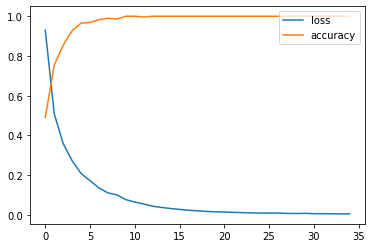

Auc =  0.8997695852534562
Acc =  0.9041095890410958
f1_score =  0.9041095890410958
average_precision =  0.9041095890410958
recall_score =  0.9041095890410958


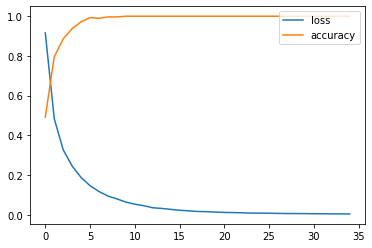

Auc =  0.8214285714285715
Acc =  0.8472222222222222
f1_score =  0.8472222222222222
average_precision =  0.8472222222222222
recall_score =  0.8472222222222222


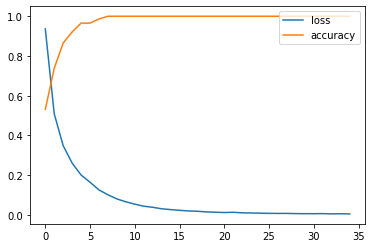

Auc =  0.9500000000000001
Acc =  0.9583333333333334
f1_score =  0.9583333333333334
average_precision =  0.9583333333333334
recall_score =  0.9583333333333334


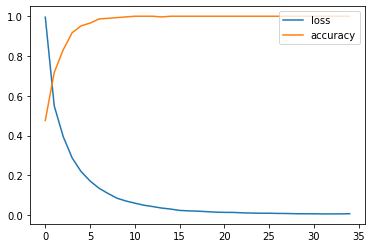

Auc =  0.9595238095238094
Acc =  0.9583333333333334
f1_score =  0.9583333333333334
average_precision =  0.9583333333333334
recall_score =  0.9583333333333334


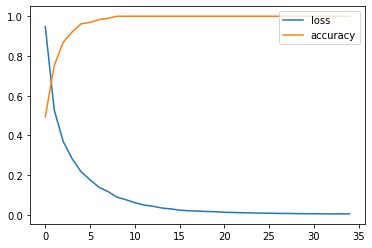

0.9171613394216134

In [26]:
#三核 四折交叉验证最佳结果
outer = RepeatedStratifiedKFold(n_splits = 5,n_repeats=1,random_state=2652124)      #数据集进行分层交叉验证划分训练集和测试集
Sum_acc = 0
for train_index,test_index in outer.split(X,Y):
    train_X,test_X = X[train_index],X[test_index]
    train_Y,test_y = y[train_index],Y[test_index]
    
    clf = MALDINet.MultiClassEstimator(kernel_block='MK',dense_layers=[128,64],batch_size=128,epochs=35,gpuid=3)
    clf.fit(train_X, train_Y)

    y_pred = clf.predict(test_X)
    #MADLINet Test Metrics
    auc = roc_auc_score(test_y, y_pred)
    acc = accuracy_score(test_y,y_pred)
    rec = recall_score(test_y, y_pred,average="micro")
    f1 = f1_score(test_y, y_pred,average="micro")
    pr = precision_score(test_y, y_pred,average="micro")
    print("Auc = ",auc)
    print("Acc = ",acc)
    print("f1_score = ",f1)
    print("average_precision = ",pr)
    print("recall_score = ",rec)
    Sum_acc += acc
    #plot train curve
    PlotCurve(clf.history)
Sum_acc / 5

Auc =  0.9050387596899225
Acc =  0.9178082191780822
f1_score =  0.9178082191780822
average_precision =  0.9178082191780822
recall_score =  0.9178082191780822


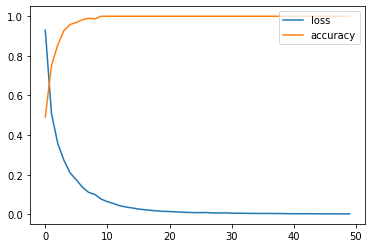

Auc =  0.911674347158218
Acc =  0.9178082191780822
f1_score =  0.9178082191780822
average_precision =  0.9178082191780822
recall_score =  0.9178082191780822


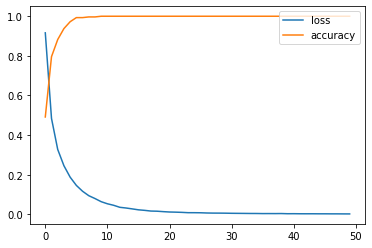

Auc =  0.8547619047619048
Acc =  0.875
f1_score =  0.875
average_precision =  0.875
recall_score =  0.875


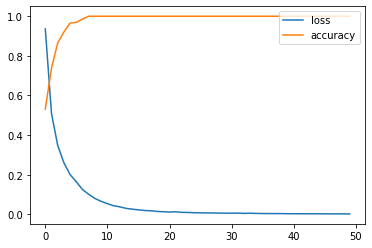

Auc =  0.9261904761904762
Acc =  0.9305555555555556
f1_score =  0.9305555555555556
average_precision =  0.9305555555555556
recall_score =  0.9305555555555556


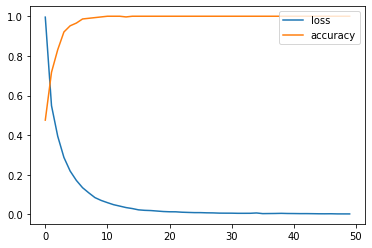

Auc =  0.9476190476190476
Acc =  0.9444444444444444
f1_score =  0.9444444444444444
average_precision =  0.9444444444444444
recall_score =  0.9444444444444444


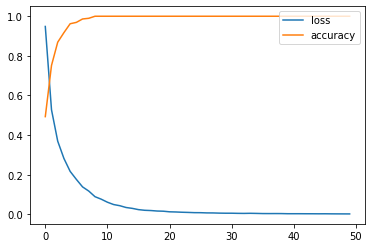

0.917123287671233

In [29]:
#三核 四折交叉验证最佳结果
outer = RepeatedStratifiedKFold(n_splits = 5,n_repeats=1,random_state=2652124)      #数据集进行分层交叉验证划分训练集和测试集
Sum_acc = 0
for train_index,test_index in outer.split(X,Y):
    train_X,test_X = X[train_index],X[test_index]
    train_Y,test_y = y[train_index],Y[test_index]
    
    clf = MALDINet.MultiClassEstimator(kernel_block='MK',dense_layers=[128,64],batch_size=128,epochs=50,gpuid=3)
    clf.fit(train_X, train_Y)

    y_pred = clf.predict(test_X)
    #MADLINet Test Metrics
    auc = roc_auc_score(test_y, y_pred)
    acc = accuracy_score(test_y,y_pred)
    rec = recall_score(test_y, y_pred,average="micro")
    f1 = f1_score(test_y, y_pred,average="micro")
    pr = precision_score(test_y, y_pred,average="micro")
    print("Auc = ",auc)
    print("Acc = ",acc)
    print("f1_score = ",f1)
    print("average_precision = ",pr)
    print("recall_score = ",rec)
    Sum_acc += acc
    #plot train curve
    PlotCurve(clf.history)
Sum_acc / 5

### 2.minfre=0.8

In [37]:
dfx = LoadMSData(root_path = root_path, data_path = 'data7/peaks_0.8.csv', t = False)
Y = np.zeros((362,2))                                             #将标签以独热编码存起来362
for i in range (0,211):                                           #阳性211例
    Y[i,1] = 1                                                     #阳性标签为1
for i in range (211,362):                                         #阴性151例
    Y[i,0] = 1                                                    #阴性标签为0
    
y = Y.astype(int)
Y = np.zeros(362)                                                 #用于分层的标签
for i in range (0,211):                                           #阳性211例
    Y[i] = 1                                                      #阳性标签为1
for i in range (211,362):                                         #阴性151例
    Y[i] = 0#阴性标签为0
Y = Y.astype(int)

In [38]:
mp = AggMap(dfx, metric = 'correlation')                        #使用相关性距离
mp.fit(cluster_channels=7, emb_method = 'umap', verbose=0)      #设置通道值
SaveMpOrX(data = mp, save_path = save_path, data_num = 'data7', file_type = 'aggmap', file_name = 'aggmap_peaks_0.8.mp')

2024-01-02 10:55:14,979 - INFO - [bidd-aggmap] - Calculating distance ...
2024-01-02 10:55:14,985 - INFO - [bidd-aggmap] - the number of process is 16


100%|##########| 107/107 [00:00<00:00, 621.27it/s]


2024-01-02 10:55:16,899 - INFO - [bidd-aggmap] - applying hierarchical clustering to obtain group information ...
2024-01-02 10:55:17,450 - INFO - [bidd-aggmap] - Applying grid assignment of feature points, this may take several minutes(1~30 min)
2024-01-02 10:55:17,468 - INFO - [bidd-aggmap] - Finished


In [39]:
# Transoformation of 1d vectors to 3D Fmaps (-1, w, h, c) by AggMap
X = mp.batch_transform(dfx.values, n_jobs=4, scale_method = 'minmax')
#SaveMpOrX(data = X, save_path = save_path, data_num = 'data1', file_type = 'Xdata', file_name = 'X_human_0.2.dat')

100%|##########| 362/362 [00:04<00:00, 88.27it/s] 


Auc =  0.9883720930232558
Acc =  0.9863013698630136
f1_score =  0.9863013698630136
average_precision =  0.9863013698630136
recall_score =  0.9863013698630136


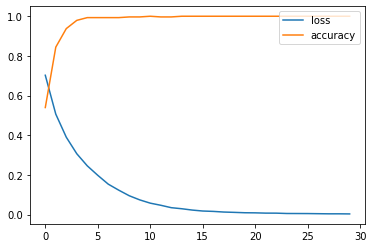

Auc =  0.967741935483871
Acc =  0.9726027397260274
f1_score =  0.9726027397260274
average_precision =  0.9726027397260274
recall_score =  0.9726027397260274


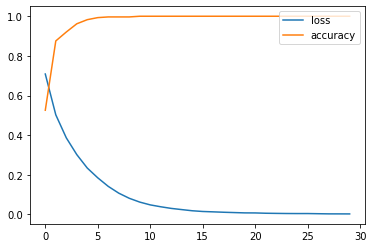

Auc =  0.9547619047619048
Acc =  0.9583333333333334
f1_score =  0.9583333333333334
average_precision =  0.9583333333333334
recall_score =  0.9583333333333334


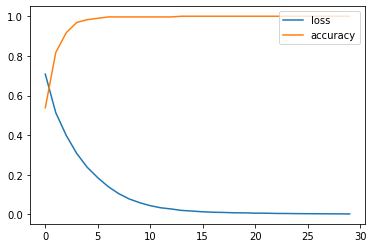

Auc =  1.0
Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


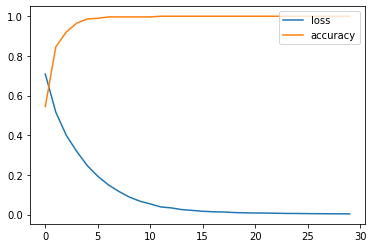

Auc =  0.9714285714285715
Acc =  0.9722222222222222
f1_score =  0.9722222222222222
average_precision =  0.9722222222222222
recall_score =  0.9722222222222222


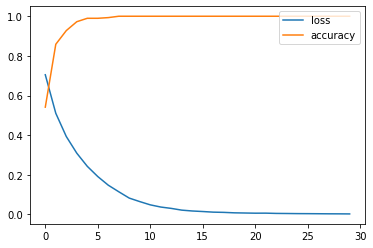

0.9778919330289193

In [50]:
#三核 四折交叉验证最佳结果
outer = RepeatedStratifiedKFold(n_splits = 5,n_repeats=1,random_state=2652124)      #数据集进行分层交叉验证划分训练集和测试集
Sum_acc = 0
for train_index,test_index in outer.split(X,Y):
    train_X,test_X = X[train_index],X[test_index]
    train_Y,test_y = y[train_index],Y[test_index]
    
    clf = MALDINet.MultiClassEstimator(kernel_block='MK',dense_layers=[256,128,64,32],batch_size=128,epochs=30,gpuid=3)
    clf.fit(train_X, train_Y)

    y_pred = clf.predict(test_X)
    #MADLINet Test Metrics
    auc = roc_auc_score(test_y, y_pred)
    acc = accuracy_score(test_y,y_pred)
    rec = recall_score(test_y, y_pred,average="micro")
    f1 = f1_score(test_y, y_pred,average="micro")
    pr = precision_score(test_y, y_pred,average="micro")
    print("Auc = ",auc)
    print("Acc = ",acc)
    print("f1_score = ",f1)
    print("average_precision = ",pr)
    print("recall_score = ",rec)
    Sum_acc += acc
    #plot train curve
    PlotCurve(clf.history)
Sum_acc / 5

Auc =  0.9883720930232558
Acc =  0.9863013698630136
f1_score =  0.9863013698630136
average_precision =  0.9863013698630136
recall_score =  0.9863013698630136


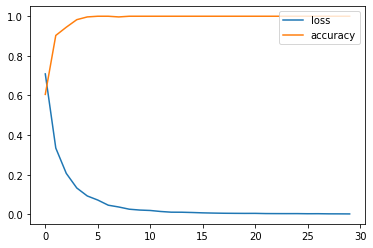

Auc =  0.9880952380952381
Acc =  0.9863013698630136
f1_score =  0.9863013698630136
average_precision =  0.9863013698630136
recall_score =  0.9863013698630136


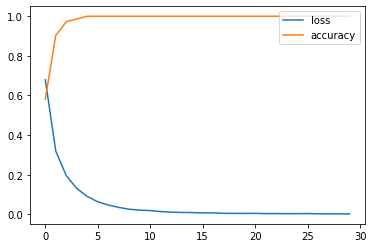

Auc =  0.9500000000000001
Acc =  0.9583333333333334
f1_score =  0.9583333333333334
average_precision =  0.9583333333333334
recall_score =  0.9583333333333334


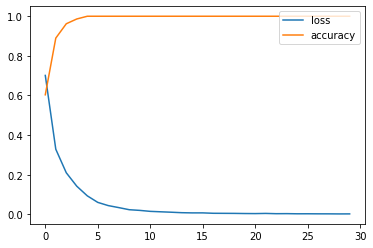

Auc =  1.0
Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


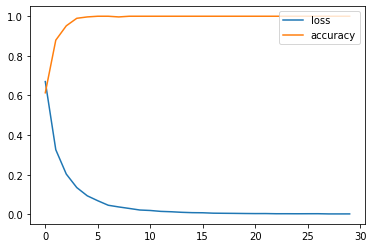

Auc =  0.9833333333333334
Acc =  0.9861111111111112
f1_score =  0.9861111111111112
average_precision =  0.9861111111111112
recall_score =  0.9861111111111112


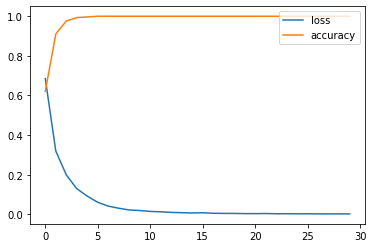

0.9834094368340944

In [53]:
#三核 四折交叉验证最佳结果
outer = RepeatedStratifiedKFold(n_splits = 5,n_repeats=1,random_state=2652124)      #数据集进行分层交叉验证划分训练集和测试集
Sum_acc = 0
for train_index,test_index in outer.split(X,Y):
    train_X,test_X = X[train_index],X[test_index]
    train_Y,test_y = y[train_index],Y[test_index]
    
    clf = MALDINet.MultiClassEstimator(kernel_block='MK',dense_layers=[128,64,32],batch_size=64,epochs=30,gpuid=3)
    clf.fit(train_X, train_Y)

    y_pred = clf.predict(test_X)
    #MADLINet Test Metrics
    auc = roc_auc_score(test_y, y_pred)
    acc = accuracy_score(test_y,y_pred)
    rec = recall_score(test_y, y_pred,average="micro")
    f1 = f1_score(test_y, y_pred,average="micro")
    pr = precision_score(test_y, y_pred,average="micro")
    print("Auc = ",auc)
    print("Acc = ",acc)
    print("f1_score = ",f1)
    print("average_precision = ",pr)
    print("recall_score = ",rec)
    Sum_acc += acc
    #plot train curve
    PlotCurve(clf.history)
Sum_acc / 5